In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from soupsieve.util import lower
from tensorflow.keras.layers import LeakyReLU

In [2]:
import requests

yearly = True
response = requests.get(f'http://localhost/api/v1/scfa/balancesheet?yearly={yearly}')
balance_sheet = response.json()
balance_sheet

{'2000': {'BBC': {'cash': 8,
   'asset': 107,
   'debt': 74,
   'equity': 33,
   'payable': 74}},
 '2001': {'TCB': {'cash': 29,
   'asset': 2388,
   'debt': 2273,
   'equity': 116,
   'payable': 2273},
  'BBC': {'cash': 13, 'asset': 163, 'debt': 80, 'equity': 83, 'payable': 80}},
 '2002': {'VNM': {'cash': 0, 'asset': 0, 'debt': 0, 'equity': 0, 'payable': 0},
  'TCB': {'cash': 63,
   'asset': 4060,
   'debt': 3929,
   'equity': 131,
   'payable': 3929},
  'STB': {'cash': 187,
   'asset': 4296,
   'debt': 3945,
   'equity': 352,
   'payable': 3945},
  'NHC': {'cash': 5, 'asset': 15, 'debt': 1, 'equity': 13, 'payable': 1},
  'FPT': {'cash': 103,
   'asset': 550,
   'debt': 517,
   'equity': 33,
   'payable': 517},
  'BBC': {'cash': 13, 'asset': 177, 'debt': 101, 'equity': 76, 'payable': 101},
  'AGF': {'cash': 2, 'asset': 168, 'debt': 102, 'equity': 66, 'payable': 102},
  'ACB': {'cash': 206,
   'asset': 9350,
   'debt': 8860,
   'equity': 489,
   'payable': 8860}},
 '2003': {'VSH': {'cas

In [3]:
# Select features for prediction
# feature_cols = ['asset', 'debt', 'equity', 'cash', 'payable']
feature_cols = ['asset']

In [113]:
# Convert balance_sheet dictionary to pandas DataFrame
rows = []
for year, companies in balance_sheet.items():
    for symbol, metrics in companies.items():
        row = {'year': int(year), 'symbol': symbol}
        row.update(metrics)
        rows.append(row)

df_balance_sheet = pd.DataFrame(rows)
df_balance_sheet = df_balance_sheet.sort_values(['symbol', 'year']).reset_index(drop=True)
df_balance_sheet = df_balance_sheet.fillna(value=0)

# Process each company separately
symbols = df_balance_sheet['symbol'].unique()

In [193]:
df_balance_sheet[df_balance_sheet['symbol'] == 'YEG']

,year,symbol,cash,asset,debt,equity,payable
22744,2012,YEG,11,86,40,45,40
22745,2013,YEG,11,188,113,65,113
22746,2014,YEG,12,245,154,91,154
22747,2015,YEG,7,350,248,101,248
22748,2016,YEG,13,355,245,110,245
22749,2017,YEG,42,657,325,333,325
22750,2018,YEG,192,1962,404,1558,404
22751,2019,YEG,162,1515,494,1021,494
22752,2020,YEG,36,1385,505,880,505
22753,2021,YEG,4,1372,495,878,495


In [194]:
# Create sequences for multivariate LSTM
def create_multivariate_dataset(dataset, look_back=1):
    """
    This default will create a dataset where X is the data for each feature at a given time (t),
    and Y is data at the next time (t + 1).
    :parms
        dataset: the dataset, which is a NumPy array you want to convert into a dataset
        look_back: which is the number of previous time steps to use as input variables to predict the next time period
    """
    data_x, data_y = [], []
    for i in range(len(dataset) -look_back - 1):
        a = dataset[i:(i + look_back), :]
        data_x.append(a)
        data_y.append(dataset[i + look_back, :])
    return np.array(data_x), np.array(data_y)

In [216]:
from keras import Input, Sequential
from keras.src.layers import LSTM, Dropout, Dense, GRU


def prepare_lstm_model(shape: tuple, dropout: float = 0.2, dense_units: int = 10):
    layers = [
        Input(shape=shape),
        LSTM(50, activation='relu', return_sequences=True),
        GRU(50,dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
        Dropout(dropout),
        LSTM(50, activation='relu'),
        Dropout(dropout),
        Dense(dense_units),
    ]
    lstm_model = Sequential(layers)
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    return lstm_model


def prepare_lstm_model_leaky_relu(shape: tuple, dropout: float = 0.2, dense_units: int = 10):
    layers = [
        Input(shape=shape),
        LSTM(50, activation='relu', return_sequences=True),
        LeakyReLU(),
        Dropout(dropout),
        LSTM(50, activation='relu'),
        LeakyReLU(),
        Dropout(dropout),
        Dense(dense_units),
    ]
    lstm_model = Sequential(layers)
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    return lstm_model

# Learning with one2one relationship

In [ ]:
import datetime

# Determine epochs and batch_size based on data size
# Create LSTM model for multivariate prediction
today = datetime.datetime.today()
boundary_year = today.year - 2
look_back = today.year - boundary_year
model = prepare_lstm_model(shape=(look_back, len(feature_cols)), dense_units=len(feature_cols))
today = datetime.datetime.today()
print(f"{boundary_year=}")

# create and fit the LSTM network
for symbol in symbols:
    df_symbol = df_balance_sheet[df_balance_sheet['symbol'] == symbol].copy()

    # Skip if not enough data
    if len(df_symbol) < 4:
        print(f"Skipping {symbol}: insufficient data (need at least 4 years)")
        continue

    # Adjust epochs and batch_size based on actual symbol data size
    symbol_data_size = len(df_symbol)
    epochs = min(100, max(50, symbol_data_size * 10))
    batch_size = max(1, min(32, symbol_data_size // 4))

    print(f"Training {symbol} with {symbol_data_size} data points: epochs={epochs}, batch_size={batch_size}")

    # Use all feature columns for multivariate prediction
    data = df_symbol[feature_cols].values

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split into train and test sets based on year
    # Train: year <= today.year - 2, Test: year > today.year - 2
    train_mask = df_symbol['year'] < boundary_year
    test_mask = df_symbol['year'] >= boundary_year

    train_data = scaled_data[train_mask.values]
    test_data = scaled_data[test_mask.values]

    # Skip if not enough data in either set
    if len(train_data) < look_back + 1 or len(test_data) < 1:
        print(f"Skipping {symbol}: insufficient train or test data")
        continue

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multivariate_dataset(train_data, look_back)
    testX, testY = create_multivariate_dataset(test_data, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, len(feature_cols)))
    testX = np.reshape(testX, (testX.shape[0], look_back, len(feature_cols)))

    # Skip if not enough sequences
    if len(trainX) == 0:
        print(f"Skipping {symbol}: cannot create sequences")
        continue

    # Fit with verbose=0 to avoid the progress bar error
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
    print(f"Model trained for {symbol}")

# Save the entire model in the recommended .keras format
model.save('balancesheet_all_symbols_lstm_model.keras')


**Summary:** The user wants to fix the MSE calculation in the selected cell. The issue is that MSE is currently calculated on the scaled (normalized) data, then the values are inverse transformed separately. The correct approach is to inverse transform the predictions and actual values first, then calculate MSE on the actual scale.

**Solution:** Calculate MSE after inverse transforming both predictions and actual values.



Train MSE: 54918113.33
Train RMSE: 7410.68


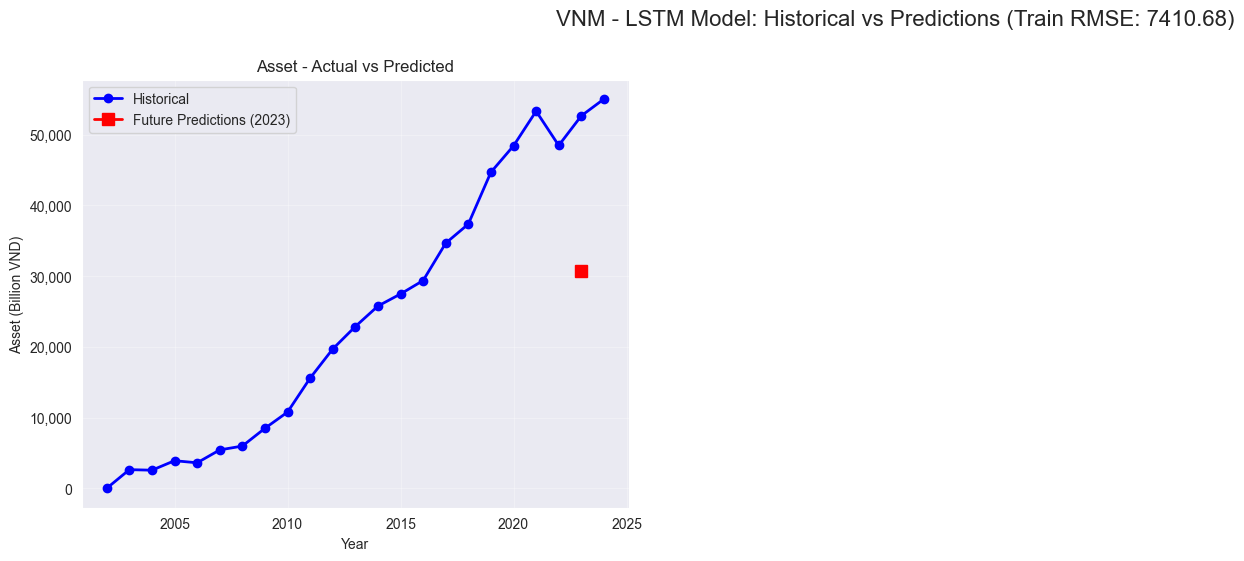


Predictions for VNM

Year 2023:
  Asset: 30,678.48 Billion VND


In [260]:
# Load the saved model and make predictions
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('balancesheet_all_symbols_lstm_model.keras')

# Visualize training results and make predictions to 2026
symbol_prediction = "VNM"
df_symbol = df_balance_sheet[df_balance_sheet['symbol'] == symbol_prediction].copy()
future_years = [2023]

# Check if we have enough data
if len(df_symbol) < look_back + 2:
    print(f"Insufficient data for {symbol_prediction}. Need at least {look_back + 2} years.")
else:
    data = df_symbol[feature_cols].values

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split into train and test sets
    train_mask = df_symbol['year'] <= boundary_year

    train_data = scaled_data[train_mask.values]

    # Create sequences for train data
    trainX, trainY = create_multivariate_dataset(train_data, look_back)

    # Make predictions on train data
    train_predictions = loaded_model.predict(trainX, verbose=0)

    # Inverse transform BEFORE calculating metrics
    train_predictions_actual = scaler.inverse_transform(train_predictions)
    train_actual = scaler.inverse_transform(trainY)

    # Calculate train metrics on actual scale
    train_mse = mean_squared_error(train_actual, train_predictions_actual)
    train_rmse = np.sqrt(train_mse)
    print(f'Train MSE: {train_mse:.2f}')
    print(f'Train RMSE: {train_rmse:.2f}')

    # Predict future years (2025, 2026)
    last_sequence = scaled_data[-look_back:].copy()
    future_predictions = []

    for _ in range(len(future_years)):
        pred_input = last_sequence.reshape(1, look_back, len(feature_cols))
        pred = loaded_model.predict(pred_input, verbose=0)
        future_predictions.append(pred[0])
        last_sequence = np.vstack([last_sequence[1:], pred[0]])

    # Inverse transform predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions))

    # Prepare data for plotting
    actual_data = scaler.inverse_transform(scaled_data)

    # Plot actual vs predicted with future predictions
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, col in enumerate(feature_cols):
        ax = axes[i]

        # Plot historical data
        ax.plot(df_symbol['year'], actual_data[:, i],
                marker='o', label='Historical', linewidth=2, color='blue')

        # Plot future predictions (2025-2026)
        ax.plot(future_years, future_predictions[:, i],
                marker='s', label='Future Predictions (2023)',
                linewidth=2, color='red', markersize=8)

        ax.set_title(f'{col.capitalize()} - Actual vs Predicted')
        ax.set_xlabel('Year')
        ax.set_ylabel(f'{col.capitalize()} (Billion VND)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # Hide unused subplot if only one feature
    if len(feature_cols) < 6:
        for j in range(len(feature_cols), 6):
            fig.delaxes(axes[j])

    plt.suptitle(
        f'{symbol_prediction} - LSTM Model: Historical vs Predictions (Train RMSE: {train_rmse:.2f})',
        fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()

    # Display prediction results
    print(f"\n{'=' * 60}")
    print(f"Predictions for {symbol_prediction}")
    print(f"{'=' * 60}")
    for year_idx, year in enumerate(future_years):
        print(f"\nYear {year}:")
        for col_idx, col in enumerate(feature_cols):
            print(f"  {col.capitalize()}: {future_predictions[year_idx, col_idx]:,.2f} Billion VND")


In [261]:
visual_cols = ["year", "symbol"] + feature_cols
df_balance_sheet[df_balance_sheet['symbol'] == symbol_prediction][visual_cols]

,year,symbol,asset
21628,2002,VNM,0
21629,2003,VNM,2632
21630,2004,VNM,2556
21631,2005,VNM,3898
21632,2006,VNM,3601
21633,2007,VNM,5425
21634,2008,VNM,5967
21635,2009,VNM,8482
21636,2010,VNM,10773
21637,2011,VNM,15583
